# Final project notebook

Welcome to this notebook that includes all the neccesary code for the final Coursera Capstone Project: Mystery city recommender.

We will start off by importing the libraries that we will need.

In [17]:
import json
import urllib.request
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats # import statistics package
import geopy.distance # calculates distance between points
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import some sklearn packages for ML purposes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics

# natural language processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Part 1: Data collection

First, we will fetch the ODS data the top 1000 US cities based on population data.

In [2]:
df = pd.read_csv('https://data.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates@public/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true', 
                 sep=';', index_col='Rank').sort_index()
df.head()

,City,State,Growth From 2000 to 2013,Population,Coordinates
Rank,,,,,
1,New York,New York,4.8,8405837,"40.7127837,-74.0059413"
2,Los Angeles,California,4.8,3884307,"34.0522342,-118.2436849"
3,Chicago,Illinois,-6.1,2718782,"41.8781136,-87.6297982"
4,Houston,Texas,11.0,2195914,"29.7604267,-95.3698028"
5,Philadelphia,Pennsylvania,2.6,1553165,"39.9525839,-75.1652215"


Now let's split the Coordinates column in seperate Latitide and Longitude columns.

In [3]:
df['Latitude'], df['Longitude'] = df['Coordinates'].str.split(",").str
df.drop('Coordinates', axis=1, inplace=True)
df = df.head(100) # We are only interested in the top 100 cities, sorted on population
df.head()

,City,State,Growth From 2000 to 2013,Population,Latitude,Longitude
Rank,,,,,,
1,New York,New York,4.8,8405837,40.7127837,-74.0059413
2,Los Angeles,California,4.8,3884307,34.0522342,-118.2436849
3,Chicago,Illinois,-6.1,2718782,41.8781136,-87.6297982
4,Houston,Texas,11.0,2195914,29.7604267,-95.3698028
5,Philadelphia,Pennsylvania,2.6,1553165,39.9525839,-75.1652215


### Fetching elevation data

The next step is to aquire elevation details for these cities, we will use the Google Maps Elevation API to fetch this data based on the center coordinates of these cities. Let's start off with defining the function that we will use to call the Elevation API.

In [4]:
def elevation(lat, lng):
    apikey = "yourAPIKEYhere" # Insert your API key here
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    request = urllib.request.urlopen(url+"?locations="+str(lat)+","+str(lng)+"&key="+apikey)
    try:
        results = json.load(request).get('results')
        while 0 < len(results):
            elevation = results[0].get('elevation')
            return elevation
        else:
            print('HTTP GET Request failed, try again')
    except ValueError as e:
        print('JSON decode failed: '+str(request))

Now let's use our data to fetch the elevation in meters for each coordinate vector.

In [5]:
df['elevation'] = df.apply(lambda row: elevation(row['Latitude'], row['Longitude']), axis=1)
df.head()

,City,State,Growth From 2000 to 2013,Population,Latitude,Longitude,elevation
Rank,,,,,,,
1,New York,New York,4.8,8405837,40.7127837,-74.0059413,13.347621
2,Los Angeles,California,4.8,3884307,34.0522342,-118.2436849,86.847092
3,Chicago,Illinois,-6.1,2718782,41.8781136,-87.6297982,183.000000
4,Houston,Texas,11.0,2195914,29.7604267,-95.3698028,14.566981
5,Philadelphia,Pennsylvania,2.6,1553165,39.9525839,-75.1652215,14.326541


### Fetching climate data

Next up, we will include data for the average annual temperature and precipitation per city. We will be using NOAA's US 1981-2010 Climate Normals open dataset. First, we will gather all available weather stations in the dataset.

In [6]:
stations = pd.read_fwf('https://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/station-inventories/temp-inventory.txt', 
                 header=None)
stations.columns = ['ID', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name', 'Gsnflag', 'Hcnflag', 'Wmoid', 'Method']
stations.head()

,ID,Latitude,Longitude,Elevation,State,Name,Gsnflag,Hcnflag,Wmoid,Method
0,AQW00061705,-14.3306,-170.7136,3.7,AS,PAGO PAGO WSO AP,GSN,NaN,91765.0,TRADITIONAL
1,CAW00064757,44.2325,-79.7811,246.0,ON,EGBERT 1 W,NaN,NaN,NaN,PSEUDONORMALS
2,CQC00914080,15.2136,145.7497,252.1,MP,CAPITOL HILL 1,NaN,NaN,NaN,TRADITIONAL
3,CQC00914801,14.1717,145.2428,179.2,MP,ROTA AP,NaN,NaN,91221.0,TRADITIONAL
4,FMC00914395,5.3544,162.9533,2.1,FM,KOSRAE,NaN,NaN,91355.0,TRADITIONAL


Now, we will combine temperature and percipitation data for every weather station in the dataset.

In [7]:
# Fetch climate normal average annual temperature per weather station:
ann_tavg = pd.read_fwf('https://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/products/temperature/ann-tavg-normal.txt',
                              header=None)
ann_tavg.columns = ['ID', 'Temperature']
# clean data and convert value to Celcius:
ann_tavg.Temperature = ann_tavg.Temperature.map(lambda x: x[:-1]).apply(lambda x: (pd.to_numeric(x)/10 - 32) * 5/9)

# Fetch climate normal average annual percipitation per weather station:
ann_pcp = pd.read_fwf('https://www1.ncdc.noaa.gov/pub/data/normals/1981-2010/products/precipitation/ann-prcp-normal.txt',
                     header=None)
ann_pcp.columns = ['ID', 'Percipitation']
# clean data and convert value to Millimeters:
ann_pcp.Percipitation = ann_pcp.Percipitation.map(lambda x: x[:-1]).apply(lambda x: pd.to_numeric(x) * 0.254)

Then, we will merge the Temperature and Percipitation datasets with the weather station inventory.

In [8]:
stations = pd.merge(stations, ann_tavg, how='left', on='ID')
stations = pd.merge(stations, ann_pcp, how='left', on='ID')
stations.describe()

,Latitude,Longitude,Elevation,Wmoid,Temperature,Percipitation
count,7501.000000,7501.000000,7501.000000,453.000000,7501.000000,6969.000000
mean,39.299392,-97.050719,553.389401,73544.333333,11.773778,874.408321
std,6.887016,22.332157,605.790399,4595.338905,5.389976,486.971703
min,-14.330600,-176.650000,-59.100000,69014.000000,-11.388889,59.944000
25%,35.070000,-109.082800,136.600000,72288.000000,7.888889,456.438000
50%,39.470800,-95.626100,298.700000,72469.000000,11.055556,888.238000
75%,43.331100,-84.555300,794.000000,72654.000000,15.555556,1183.386000
max,71.283300,174.100000,3442.400000,91765.000000,28.222222,6096.508000


That seems to be working perfectly! Now, we can finally use all the acquired data to learn about our top US cities. We will setup a function that selects the weather stations within a 20 km radius of the city centers. Then, we will average the temperature and percipitation of these weather stations and summarize this in two feature columns.

In [9]:
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')
def climate(lat, lng):
    stations['dist'] = stations.apply(lambda row: geopy.distance.distance([lat, lng], [row['Latitude'], row['Longitude']]).km, axis=1)
    selection = stations[stations.dist <= 20]
    avg_temp, avg_pcp = selection.Temperature.mean(), selection.Percipitation.mean()
    return pd.Series([avg_temp, avg_pcp])

df[['Avg_temperature','Avg_percipitation']] = df.apply(lambda row: climate(row['Latitude'], row['Longitude']), axis=1)
df.head()

,City,State,Growth From 2000 to 2013,Population,Latitude,Longitude,elevation,Avg_temperature,Avg_percipitation
Rank,,,,,,,,,
1,New York,New York,4.8,8405837,40.712784,-74.005941,13.347621,12.793651,1208.0240
2,Los Angeles,California,4.8,3884307,34.052234,-118.243685,86.847092,18.061111,408.1272
3,Chicago,Illinois,-6.1,2718782,41.878114,-87.629798,183.000000,11.111111,978.5350
4,Houston,Texas,11.0,2195914,29.760427,-95.369803,14.566981,21.388889,1337.0560
5,Philadelphia,Pennsylvania,2.6,1553165,39.952584,-75.165222,14.326541,13.333333,1176.0835


### Fetching venue data

Finally, we will use the Foursquare API to gather venue data for the top cities. Let's start off by connecting to the Foursquare API.

#### Define Foursquare Credentials and Version

In [10]:
CLIENT_ID = 'yourIDhere' # your Foursquare ID
CLIENT_SECRET = 'yourSECREThere' # your Foursquare Secret
VERSION = '20191013' # Foursquare API version

Now, let's create some functions that will call the Foursquare API and fetch the required data for each city.

In [11]:
LIMIT = 100 # According to the Foursquare docs, this is the maximum limit.
radius = 5000 # Everything in a 5km radius from the center coordinates.

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
# function that connects to the foursquare API and returns the results
def fetch_venues(lat, lng):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    qty = results['response']['totalResults'] # total amount of reported venues within range
    
    # now lets group the fetched venues by category and only keep the most popular top 3
    venues = json_normalize(results['response']['groups'][0]['items']) # flatten JSON and put in pandas dataframe
    venues = venues.loc[:, ['venue.categories']] # filter results and only keep categories
    venues['venue.categories'] = venues.apply(get_category_type, axis=1) # filter the category for each row
    
    # keep only the top 3 venues
    top3_venues = venues['venue.categories'].value_counts()[0:3]
    
    return pd.Series([qty, top3_venues.index.tolist()])

And let's apply these functions to our dataframe.

In [14]:
df[['Count of Venues','Top 3 categories']] = df.apply(lambda row: fetch_venues(row['Latitude'], row['Longitude']), axis=1)
df.head()

,City,State,Growth From 2000 to 2013,Population,Latitude,Longitude,elevation,Avg_temperature,Avg_percipitation,Count of Venues,Top 3 categories
Rank,,,,,,,,,,,
1,New York,New York,4.8,8405837,40.712784,-74.005941,13.347621,12.793651,1208.0240,237,"[Park, Italian Restaurant, Hotel]"
2,Los Angeles,California,4.8,3884307,34.052234,-118.243685,86.847092,18.061111,408.1272,236,"[Coffee Shop, Ice Cream Shop, Art Gallery]"
3,Chicago,Illinois,-6.1,2718782,41.878114,-87.629798,183.000000,11.111111,978.5350,237,"[Hotel, Theater, Park]"
4,Houston,Texas,11.0,2195914,29.760427,-95.369803,14.566981,21.388889,1337.0560,242,"[Hotel, Brewery, Cocktail Bar]"
5,Philadelphia,Pennsylvania,2.6,1553165,39.952584,-75.165222,14.326541,13.333333,1176.0835,238,"[Coffee Shop, Pizza Place, Vegetarian / Vegan ..."


# Part 2: Data pre-processing

Now it's time to prepare the acquired data so our model will be able to process it. First of all we notice that the top 3 venue categories consist of a list with string formatting, which our model will not be able to process. Therefore, we will start off by cleaning this column by converting all text to lowercase characters and then trimming the spaces inbetween words.

Next, we will use the stopwords dataset from the nltk library to remove any possible stop words. We will then apply the resulting cleaned string to our dataframe.

In [15]:
def clean(cat):
    cat = [str.lower(i.replace(" ", "")) for i in cat]
    cat_keywords = [word for word in cat if word not in stopwords.words('english')]
    merged_cat = " ".join(cat_keywords)
    return merged_cat

In [18]:
df['BagOfWords'] = df.apply(lambda row: clean(row['Top 3 categories']), axis=1)
df.head()

,City,State,Growth From 2000 to 2013,Population,Latitude,Longitude,elevation,Avg_temperature,Avg_percipitation,Count of Venues,Top 3 categories,BagOfWords
Rank,,,,,,,,,,,,
1,New York,New York,4.8,8405837,40.712784,-74.005941,13.347621,12.793651,1208.0240,237,"[Park, Italian Restaurant, Hotel]",park italianrestaurant hotel
2,Los Angeles,California,4.8,3884307,34.052234,-118.243685,86.847092,18.061111,408.1272,236,"[Coffee Shop, Ice Cream Shop, Art Gallery]",coffeeshop icecreamshop artgallery
3,Chicago,Illinois,-6.1,2718782,41.878114,-87.629798,183.000000,11.111111,978.5350,237,"[Hotel, Theater, Park]",hotel theater park
4,Houston,Texas,11.0,2195914,29.760427,-95.369803,14.566981,21.388889,1337.0560,242,"[Hotel, Brewery, Cocktail Bar]",hotel brewery cocktailbar
5,Philadelphia,Pennsylvania,2.6,1553165,39.952584,-75.165222,14.326541,13.333333,1176.0835,238,"[Coffee Shop, Pizza Place, Vegetarian / Vegan ...",coffeeshop pizzaplace vegetarian/veganrestaurant


Now let's check the data types to ensure correct data handling.

In [19]:
df.dtypes

City                         object
State                        object
Growth From 2000 to 2013    float64
Population                    int64
Latitude                    float64
Longitude                   float64
elevation                   float64
Avg_temperature             float64
Avg_percipitation           float64
Count of Venues               int64
Top 3 categories             object
BagOfWords                   object
dtype: object

In [20]:
df.describe()

,Growth From 2000 to 2013,Population,Latitude,Longitude,elevation,Avg_temperature,Avg_percipitation,Count of Venues
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,14.213000,6.199111e+05,36.357787,-98.386528,256.796582,15.904044,817.740830,219.550000
std,19.079359,9.465627e+05,5.409962,17.693713,375.614880,4.658078,406.472148,32.417533
min,-27.100000,2.137080e+05,21.306944,-157.858333,0.521789,2.372222,122.936000,88.000000
25%,4.650000,2.567090e+05,33.341160,-115.015666,15.474609,12.311458,409.314650,216.000000
50%,12.000000,3.791460e+05,36.158323,-96.692042,160.461349,15.791667,917.346400,233.500000
75%,19.750000,6.251940e+05,39.731883,-82.909096,281.286751,18.981481,1148.905500,238.000000
max,96.000000,8.405837e+06,61.218056,-71.058880,1831.081909,24.690476,1593.469000,246.000000


# Part 3: Explanatory data analysis

Let's start off our data analysis by looking at correlation between columns in the dataset through the use of a heatmap.

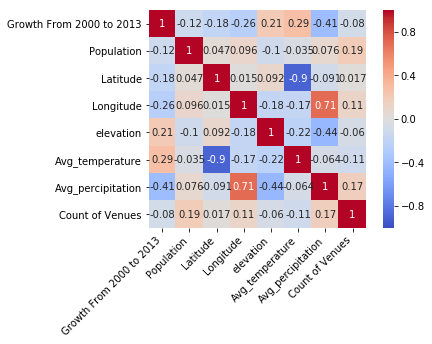

In [21]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap='coolwarm',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

It seems like there's a strong negative correlation between average temperature and Latitude and a positive correlation between average percipitation and Longitude. Let's further analyse the correlation between these variables, starting off with the dependance between the average annual temperature and coordinate latitude:

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


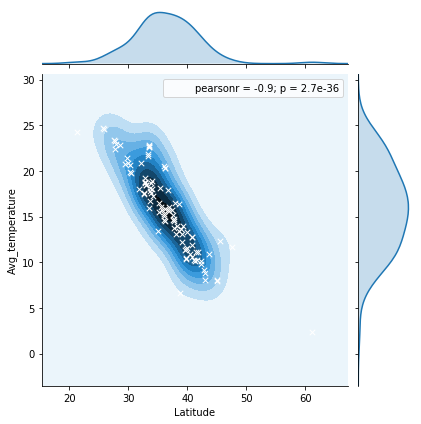

In [22]:
g = sns.jointplot(x="Latitude", y="Avg_temperature", data=df, kind="kde")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="x").annotate(stats.pearsonr)

We see an R (correlation coefficient) of -0.9 and an extremely low p-value (e^-36). This is a perfect example of a very strong negative correlation. Therefore, we can conclude that the average annual temperature decreases when the latitude increases. This is very obvious as the latitude increases when we travel further North so we would expect a lower average temperature. Our data confirms this finding. Now, let's take a look at the second relationship.

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


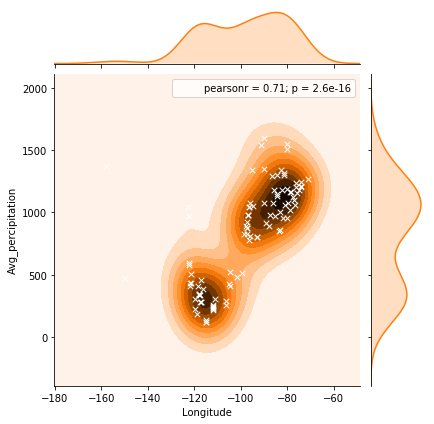

In [23]:
g = sns.jointplot(x="Longitude", y="Avg_percipitation", color='tab:orange', data=df, kind="kde")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="x").annotate(stats.pearsonr)

It becomes clear that we are dealing with two seperate clusters, one around a longitude of approximately -115 and one around -85. We also notice a pretty decent positive R value and again a very low p-value. It seems like the average annual percipitation increases as the longitude decreases. A decrease in longitude means a move towards the East. Therefore, we conclude that on average, west coast cities are much dryer than their east coast counterparts. Now let's determine if this is caused by a difference in Latitude.

Text(0.5, 1.05, 'Average annual percipitation based on coordinate vector.')

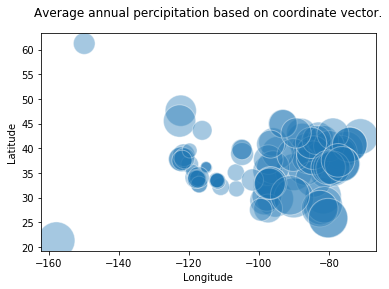

In [24]:
plt.scatter(x = "Longitude", 
            y = "Latitude", 
            s = "Avg_percipitation",
            data=df,
            alpha=0.4, 
            edgecolors='w')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Average annual percipitation based on coordinate vector.", y=1.05)

We notice some exceptions on the west coast but overall we can say that the average annual percipitation does not seem to depend on the latitude coordinates. Let's check if it is more dependent on the elevation.

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


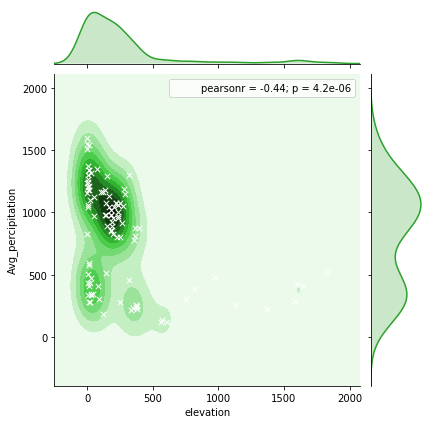

In [25]:
g = sns.jointplot(x="elevation", y="Avg_percipitation", color='tab:green', data=df, kind="kde")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="x").annotate(stats.pearsonr)

It is hard to make out a definite relationship between these variables due to the different apparent clusters. We could use a clustering algorithm to seperate the clusters and calculate the correlation statistics again but this is out of scope for this assignment. Overall it seems like there is a negative correlation between the average annual percipication and the elevation, this means that higher cities are usually dryer year around. Finally, let's take a look at the relationship between annual percipitation and average annual growth as this also appeared to be noticable from the heatmap.

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


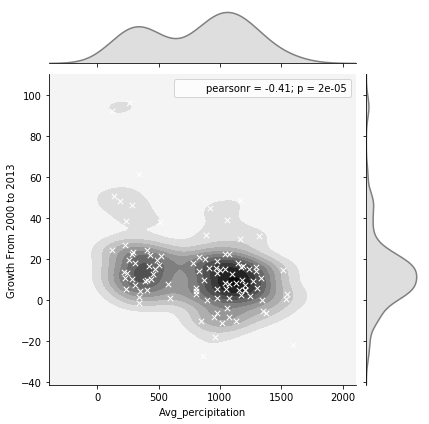

In [26]:
g = sns.jointplot(x="Avg_percipitation", y="Growth From 2000 to 2013", color='tab:gray', data=df, kind="kde")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="x").annotate(stats.pearsonr)

Again, it's hard to make out as we're dealing with two seperate clusters but it seems like a higher annual percipitation means a lower growth in population. This means dryer cities are more favourable to most people compared to wetter cities.

# Part 4: Feature selection

Now let's create our feature set based on the data, to start off we will only select relevant numerical data.

In [159]:
Features = df[['Growth From 2000 to 2013','Population','elevation','Avg_temperature','Avg_percipitation','Count of Venues']]
Features.head()

,Growth From 2000 to 2013,Population,elevation,Avg_temperature,Avg_percipitation,Count of Venues
Rank,,,,,,
1,4.8,8405837,13.347621,12.793651,1208.0240,237
2,4.8,3884307,86.847092,18.061111,408.1272,236
3,-6.1,2718782,183.000000,11.111111,978.5350,237
4,11.0,2195914,14.566981,21.388889,1337.0560,242
5,2.6,1553165,14.326541,13.333333,1176.0835,238


Let's set X as independent variables equal to the feature set.

In [160]:
X = Features

### Normalizing data

We will use the StandardScaler package from sklearn to transform the featureset into normalized data.

In [161]:
X = StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[-0.49584584,  8.26691178, -0.65139968, -0.67110569,  0.96500916,
         0.54100075],
       [-0.49584584,  3.4660583 , -0.45473615,  0.46541395, -1.0128054 ,
         0.50999784],
       [-1.07002195,  2.22853146, -0.19745851, -1.03413441,  0.3975776 ,
         0.54100075],
       [-0.16925026,  1.6733626 , -0.64813702,  1.18342312,  1.28405202,
         0.69601529],
       [-0.6117346 ,  0.99090693, -0.64878037, -0.55466251,  0.88603349,
         0.57200366]])

### Vectorizing strings

Now that we have our normalized numerical data available we will add our textual data. In order to merge both forms of data, we will first use the CountVectorizer from the sklearn package to convert the BagOfWords column to an array with the count of occurance for every category. The result is an nxm matrix with n cities and m available categories.

In [162]:
count_matrix = CountVectorizer().fit_transform(df['BagOfWords']).toarray()
count_matrix[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0]], dtype=int64)

Finally, we are ready to merge the two featuresets together.

In [163]:
X = np.concatenate((X, count_matrix), axis=1)
X

array([[-0.49584584,  8.26691178, -0.65139968, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49584584,  3.4660583 , -0.45473615, ...,  0.        ,
         0.        ,  0.        ],
       [-1.07002195,  2.22853146, -0.19745851, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24826532, -0.43073511,  1.49927049, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31674504, -0.43086571, -0.54812842, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06389685, -0.43129679,  0.16855196, ...,  0.        ,
         0.        ,  0.        ]])

# Part 5: Modelling

For our model we determined that a user should be able to input cities that they have enjoyed visiting, which will be processed by our recommender system to provide 5 matching cities based on the user's input. Because we do not have access to other user's preferences at the start of implementing this system, we will be building a content-based recommender system that uses the cosine similarity metric to determine similarity scores between the user preference and every other city. This score is quite easy to calculate by using cosine_similarity() from sklearn's package.

In [164]:
# Construct a reverse map of indices and cities
indices = pd.Series(df.index, index=df['City']).drop_duplicates()

### Recommender Engine

In [345]:
def get_recommendations(usr_input):
    # Get the index of the preferred cities and shift by one
    idx = [indices[n] - 1 for n in usr_input]

    # Lookup the corresponding featuresets for provided indices and concatenate them
    Y = np.concatenate([[X[m]] for m in idx])

    # Calculate the average preferred feature vector and reshape array
    Y = np.mean(Y, axis=0).reshape(1, -1)
    
    # Compute the cosine similarity matrix between the preferred vector and the featureset
    cossim = cosine_similarity(Y, X)

    # Get the pairwise similarity scores for all cities with that vector
    sim_scores = list(enumerate(cossim[0]))

    # Remove cities that are already mentioned in the user input
    [sim_scores.pop(z) for z in sorted(idx, reverse=True)]

    # Sort the remaining cities based on their similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Filter and obtain the 5 cities with the highest similarity scores
    sim_scores = sim_scores[0:5]

    # Fetch these city's indices
    city_indices = [i[0] for i in sim_scores]

    # Clean the scores and transform to a presentable format
    sim_scores = pd.Series(["{:.2%}".format(i[1]) for i in sim_scores])
    sim_scores.name = 'Score'
    
    # Return the top 5 recommended cities with their corresponding similarity scores
    result = pd.concat([df['City'].iloc[city_indices].reset_index(), sim_scores], axis=1)
    
    return result

Now that our engine is setup, it's time to test some examples.

In [347]:
get_recommendations(['Los Angeles', 'San Diego', 'New York'])

,Rank,City,Score
0,3,Chicago,77.21%
1,4,Houston,57.12%
2,7,San Antonio,50.36%
3,6,Phoenix,47.57%
4,9,Dallas,45.03%


In [348]:
get_recommendations(['Tampa', 'Miami'])

,Rank,City,Score
0,78,St. Petersburg,73.86%
1,93,Baton Rouge,73.57%
2,77,Orlando,72.17%
3,54,Honolulu,67.41%
4,51,New Orleans,63.83%


In [349]:
get_recommendations(['Seattle', 'Anchorage'])

,Rank,City,Score
0,83,Madison,69.88%
1,31,Milwaukee,63.26%
2,76,Fort Wayne,59.14%
3,42,Omaha,53.75%
4,72,Lincoln,53.03%


In [351]:
get_recommendations(['Las Vegas', 'Reno'])

,Rank,City,Score
0,32,Albuquerque,85.59%
1,22,Denver,75.43%
2,55,Aurora,75.08%
3,19,El Paso,71.92%
4,98,Boise City,69.49%


That seems to be working perfectly, thank you for reading!